### Importing necessary libraries

In [1]:
import numpy as np
from imageio import imread
from skimage.transform import resize
import datetime
import os
import cv2
import re
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)
import matplotlib.pyplot as plt
%matplotlib inline

Setting up random seed as per the starter code notebook so that results do not vary drastically and are as per expectations from UpGrad curriculum

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [2]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [3]:
print(len(train_doc) // 100)
print(len(train_doc)) 
print(len(val_doc))

6
663
100


##### Either we can try a batch size of 100 as that should be a maximum, however we can start with something like 64, which seems to be a good batch size, considering this to be a medium level dataset. We can check if 100 works well too later.

In [4]:
batch_size = 64     #experiment with the batch size

### Generator 1st iteration with img_idx as multiples of 3

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

### After iteration, since we need to change img_idx therefore making it an argument into the function as well, which way it would be easier to call the generator function

In [5]:
def generator(source_path, folder_list, batch_size, img_idx):
    print('Source path =', source_path, '; batch size =', batch_size)
    print(img_idx)
    img_idx = img_idx
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(folder_list) // batch_size 
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 100, 100, 3))  # Assuming final image size (100,100)
            batch_labels = np.zeros((batch_size, 5))
            
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                
                for idx, item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.resize(image, (100, 100))  # Resize to (100,100)
                    image = image / 255.0  # Normalize pixel values to [0,1]
                    
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        remaining_samples = len(folder_list) % batch_size  # Handle remaining data points
#         print(remaining_samples)

        if remaining_samples > 0:
            batch_data = np.zeros((remaining_samples, len(img_idx), 100, 100, 3))
            batch_labels = np.zeros((remaining_samples, 5))
            
            for folder in range(remaining_samples): 
                # here we can see in the next line we use num_batches, because the above batch loop runs
                # for num_batches - 1 value and therefore the last batch with extra folders should be in num_batches
                imgs = sorted(os.listdir(os.path.join(source_path, t[folder + (num_batches*batch_size)].split(';')[0])))
                
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, t[folder + (num_batches*batch_size)].strip().split(';')[0], imgs[item]))
                    image = cv2.resize(image, (100, 100))
                    image = image.astype(np.float32) / 255.0
                    
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # Yield the last batch


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

#### Tried with epochs 10 initially, did not get very good results, therefore going with 50 epochs

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


### Calling the generator 

In [8]:
# Create data generators
train_generator = generator(train_path, train_doc, batch_size, img_idx = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 29])
print('Train Generator Completed')

Train Generator Completed


##### Checking one instance of the image from the generator from train

Source path = /home/datasets/Project_data/train ; batch size = 64
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 29]
Batch data shape: (64, 11, 100, 100, 3)
Batch labels shape: (64, 5)


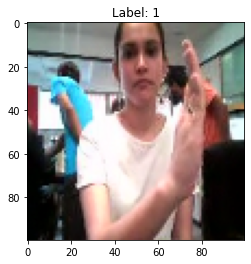

In [9]:
# Get one batch from the generator
batch_data_train, batch_labels_train = next(train_generator)

# Check the shape of the batch
print("Batch data shape:", batch_data_train.shape)  # Expected: (batch_size, x, y, z, 3)
print("Batch labels shape:", batch_labels_train.shape)  # Expected: (batch_size, num_classes)

# Check first image in the batch

plt.imshow(batch_data_train[0, 0, :, :, :])  # Visualize the first frame of the first video
plt.title(f"Label: {np.argmax(batch_labels_train[0])}")  # Get the class label
plt.show()

In [10]:
val_generator = generator(val_path, val_doc, batch_size, img_idx = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 29])
print('Val Generator Completed')

Val Generator Completed


##### Checking one instance of the image from the generator from test

Source path = /home/datasets/Project_data/val ; batch size = 64
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 29]
Batch data shape: (64, 11, 100, 100, 3)
Batch labels shape: (64, 5)


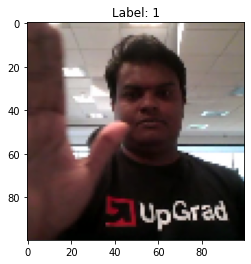

In [11]:
# Get one batch from the generator
batch_data_val, batch_labels_val = next(val_generator)

# Check the shape of the batch
print("Batch data shape:", batch_data_val.shape)  # Expected: (batch_size, x, y, z, 3)
print("Batch labels shape:", batch_labels_val.shape)  # Expected: (batch_size, num_classes)

plt.imshow(batch_data_val[0, 0, :, :, :])  # Visualize the first frame of the first video
plt.title(f"Label: {np.argmax(batch_labels_val[0])}")  # Get the class label
plt.show()

### Model Building - 1st Iteration with CNN (Conv2D + RNN (leveraging GRU) Framework)

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

##### Importing necessary layers for Deep Learning model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GRU, Dropout, Flatten, BatchNormalization
                                     , Activation, Conv3D, MaxPooling3D, Conv2D
                                     , MaxPooling2D, TimeDistributed, LSTM)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

In [13]:
# Define model
model = Sequential()

# CNN Feature Extractor using Conv2D (applied to each frame)
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(11, 100, 100, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))  # Flatten each frame before passing to GRU

# RNN Layer for Temporal Dependencies
model.add(GRU(64, return_sequences=False))  # GRU processes the sequence of frame features

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 5 output classes

2025-04-01 07:41:42.825967: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-04-01 07:41:42.826037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21985 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3e:00.0, compute capability: 8.6


In [14]:
optimiser = Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 11, 100, 100, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 11, 50, 50, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 11, 50, 50, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 11, 50, 50, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 11, 25, 25, 64)   0

In [21]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [7]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.6700 - categorical_accuracy: 0.7511
Epoch 00001: val_loss improved from inf to 2.86261, saving model to model_init_2025-04-0107_40_51.069823/model-00001-0.67003-0.75113-2.86261-0.18000.h5
11/11 [==============================] - 21s 2s/step - loss: 0.6700 - categorical_accuracy: 0.7511 - val_loss: 2.8626 - val_categorical_accuracy: 0.1800 - lr: 5.0000e-04
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.6546 - categorical_accuracy: 0.7511
Epoch 00002: val_loss did not improve from 2.86261
11/11 [==============================] - 22s 2s/step - loss: 0.6546 - categorical_accuracy: 0.7511 - val_loss: 3.3138 - val_categorical_accuracy: 0.1600 - lr: 5.0000e-04
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.6525 - categorical_accuracy: 0.7587
Epoch 00003: val_loss did not improve from 2.86261
11/11 [==============================] - 21s 2s/step - loss: 0.6525 - categorical_accura

In [24]:
print(model.evaluate(val_generator, steps=validation_steps))

2/2 [==============================] - 2s 2s/step - loss: 1.1465 - categorical_accuracy: 0.6400
[1.1464729309082031, 0.6399999856948853]


### Generator with more images from each folder and in modeling sequence part using LSTM or GRU (GRU will have less trainable parameters but want to check performance of LSTM as well) and multiple layers of them

In [29]:
train_generator_lstm = generator(train_path, train_doc, batch_size, img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])
val_generator_lstm = generator(val_path, val_doc, batch_size, img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])

In [30]:
input_shape_reqd = len([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])

### Checking the LSTM Model

In [31]:
model = Sequential()

# CNN Feature Extractor using Conv2D (applied to each frame)
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(input_shape_reqd, 100, 100, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))  # Flatten each frame before passing to LSTM

# RNN Layers for Temporal Dependencies
model.add(LSTM(128, return_sequences=True))  # First LSTM layer (returns sequences)
model.add(LSTM(64, return_sequences=False))  # Second LSTM layer (final output)

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 5 output classes

In [34]:
# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 15, 100, 100, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 15, 50, 50, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 15, 50, 50, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 15, 50, 50, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 15, 25, 25, 64)  

In [35]:
model_name = 'model_init_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [36]:
model.fit(train_generator_lstm, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_lstm, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0) #Keeping 20 epochs as LSTM has too many params

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.5101 - categorical_accuracy: 0.3092
Epoch 00001: val_loss improved from inf to 1.57076, saving model to model_init_lstm_2025-04-0107_40_51.069823/model-00001-1.51013-0.30920-1.57076-0.26000.h5
11/11 [==============================] - 33s 3s/step - loss: 1.5101 - categorical_accuracy: 0.3092 - val_loss: 1.5708 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.3746 - categorical_accuracy: 0.4012
Epoch 00002: val_loss did not improve from 1.57076
11/11 [==============================] - 29s 3s/step - loss: 1.3746 - categorical_accuracy: 0.4012 - val_loss: 1.6407 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.2366 - categorical_accuracy: 0.4962
Epoch 00003: val_loss did not improve from 1.57076
11/11 [==============================] - 29s 3s/step - loss: 1.2366 - categorical_accuracy:

In [37]:
print(model.evaluate(val_generator_lstm, steps=validation_steps))

2/2 [==============================] - 3s 3s/step - loss: 3.8769 - categorical_accuracy: 0.2800
[3.8768911361694336, 0.2800000011920929]


### GRU two layers with 50 epochs

In [38]:
model = Sequential()

# CNN Feature Extractor using Conv2D (applied to each frame)
model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(input_shape_reqd, 100, 100, 3)))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(Flatten()))  # Flatten each frame before passing to LSTM

# RNN Layers for Temporal Dependencies
model.add(GRU(128, return_sequences=True))  # First LSTM layer (returns sequences)
model.add(GRU(64, return_sequences=False))  # Second LSTM layer (final output)

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 5 output classes

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_30 (TimeDi  (None, 15, 100, 100, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 15, 50, 50, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 15, 50, 50, 32)   128       
 stributed)                                                      
                                                                 
 time_distributed_33 (TimeDi  (None, 15, 50, 50, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 15, 25, 25, 64)  

In [39]:
model_name = 'model_init_gru_v2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [40]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 64
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 1.5539 - categorical_accuracy: 0.3077Source path = /home/datasets/Project_data/val ; batch size = 64
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

Epoch 00001: val_loss improved from inf to 1.82781, saving model to model_init_gru_v2_2025-04-0107_40_51.069823/model-00001-1.55387-0.30769-1.82781-0.24000.h5
11/11 [==============================] - 34s 3s/step - loss: 1.5539 - categorical_accuracy: 0.3077 - val_loss: 1.8278 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.3825 - categorical_accuracy: 0.3906
Epoch 00002: val_loss improved from 1.82781 to 1.58875, saving model to model_init_gru_v2_2025-04-0107_40_51.069823/model-00002-1.38246-0.39065-1.58875-0.31000.h5
11/11 [==============================] - 28s 3s/step - los

#### Therefore, we noticed that even with two sequential layers to capture sequential information, we kind of have only categorical accuracy of 59%.
#### Therefore, comparatively, GRU with one layer (first model created) and less images in a sequence is the best performing so far. Now, we will create a conv3D model and check how to go about this.

### Conv3D - CNN only architecture + Fully connected Dense Networks

##### with 11 frames only

In [51]:
train_generator_conv3d = generator(train_path, train_doc, batch_size, img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])
val_generator_conv3d = generator(val_path, val_doc, batch_size, img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])

In [52]:
input_reqd = len([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])
print(input_reqd
     )

15


In [53]:
model = Sequential()

# 3D CNN Feature Extractor
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=(input_reqd, 100, 100, 3)))  
model.add(MaxPooling3D((1, 2, 2)))  # Keep time dimension unchanged
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((1, 2, 2)))  # Reduce only spatial dimensions
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))  # Reduce frames here
model.add(BatchNormalization())

model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))  # Reduce frames further
model.add(BatchNormalization())

model.add(Flatten())  # Flatten before passing to Dense layers

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 5 output classes

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Model Summary
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 15, 100, 100, 32)  2624      
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 50, 50, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 15, 50, 50, 32)   128       
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 50, 50, 64)    55360     
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 15, 25, 25, 64)   0         
 g3D)                                                            
                                                      

In [54]:
model_name = 'model_init_conv3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [55]:
model.fit(train_generator_conv3d, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_conv3d, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 64
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 4.3439 - categorical_accuracy: 0.2821Source path = /home/datasets/Project_data/val ; batch size = 64
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

Epoch 00001: saving model to model_init_conv3D_2025-04-0107_40_51.069823/model-00001-4.34388-0.28205-21.17780-0.23000.h5
11/11 [==============================] - 32s 3s/step - loss: 4.3439 - categorical_accuracy: 0.2821 - val_loss: 21.1778 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 4.4281 - categorical_accuracy: 0.3605
Epoch 00002: saving model to model_init_conv3D_2025-04-0107_40_51.069823/model-00002-4.42805-0.36048-23.03176-0.22000.h5
11/11 [==============================] - 29s 3s/step - loss: 4.4281 - categorical_accuracy: 0.3605 - val_loss: 23.0318 - val_categorical_

### We are able to get to better validation categorical accuracy with Conv3D layer with lesser computations. compared to LSTM

#### However we have noticed that we have way too many trainable parameters, what if we change it to RGB as we are focussing only on gesture recognition
##### We will try the same, create a new generator to convert images to Grayscale

In [56]:
def generator(source_path, folder_list, batch_size, img_idx):
    print('Source path =', source_path, '; batch size =', batch_size)
    print(img_idx)
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(folder_list) // batch_size 
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 100, 100, 1))  # Single channel for grayscale
            batch_labels = np.zeros((batch_size, 5))
            
            for folder in range(batch_size):
                imgs = os.listdir(os.path.join(source_path, t[folder + (batch * batch_size)].split(';')[0]))
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0], imgs[item])
                    image = imread(image_path, pilmode='L').astype(np.float32)  # Read image in grayscale
                    image = cv2.resize(image, (100, 100))  # Resize to (100,100)
                    image = image / 255.0  # Normalize pixel values to [0,1]
                    
                    batch_data[folder, idx, :, :, 0] = image  # Assign to single channel
                
                batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        remaining_samples = len(folder_list) % batch_size  # Handle remaining data points

        if remaining_samples > 0:
            batch_data = np.zeros((remaining_samples, len(img_idx), 100, 100, 1))
            batch_labels = np.zeros((remaining_samples, 5))
            
            for folder in range(remaining_samples): 
                imgs = sorted(os.listdir(os.path.join(source_path, t[folder + (num_batches * batch_size)].split(';')[0])))
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].strip().split(';')[0], imgs[item])
                    image = imread(image_path, pilmode='L').astype(np.float32)  # Read image in grayscale
                    image = cv2.resize(image, (100, 100))
                    image = image / 255.0
                    
                    batch_data[folder, idx, :, :, 0] = image  # Assign to single channel
                
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # Yield the last batch

In [57]:
train_generator_gray = generator(train_path, train_doc, batch_size, img_idx = [0,3,6,9,12,15,18,21,24,27,29])
val_generator_gray = generator(val_path, val_doc, batch_size, img_idx = [0,3,6,9,12,15,18,21,24,27,29])

In [58]:
sequence_length = len([0,3,6,9,12,15,18,21,24,27,29])
print(sequence_length)

11


In [60]:
model = Sequential()

# 3D CNN Feature Extractor
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, 100, 100, 1)))  
model.add(MaxPooling3D((1, 2, 2)))  # Keep time dimension unchanged
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((1, 2, 2)))  # Reduce only spatial dimensions
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))  # Reduce frames here
model.add(BatchNormalization())

model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))  # Reduce frames further
model.add(BatchNormalization())

model.add(Flatten())  # Flatten before passing to Dense layers

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 5 output classes

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Model Summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_23 (Conv3D)          (None, 11, 100, 100, 32)  896       
                                                                 
 max_pooling3d_22 (MaxPoolin  (None, 11, 50, 50, 32)   0         
 g3D)                                                            
                                                                 
 batch_normalization_33 (Bat  (None, 11, 50, 50, 32)   128       
 chNormalization)                                                
                                                                 
 conv3d_24 (Conv3D)          (None, 11, 50, 50, 64)    55360     
                                                                 
 max_pooling3d_23 (MaxPoolin  (None, 11, 25, 25, 64)   0         
 g3D)                                                            
                                                     

In [61]:
model_name = 'model_init_conv3d_grayscale' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [62]:
model.fit(train_generator_gray, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_gray, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 64
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 29]
Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 3.4422 - categorical_accuracy: 0.3243Source path = /home/datasets/Project_data/val ; batch size = 64
[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 29]

Epoch 00001: saving model to model_init_conv3d_grayscale_2025-04-0107_40_51.069823/model-00001-3.44217-0.32428-1.82203-0.18000.h5
11/11 [==============================] - 21s 2s/step - loss: 3.4422 - categorical_accuracy: 0.3243 - val_loss: 1.8220 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 2.5926 - categorical_accuracy: 0.3348
Epoch 00002: saving model to model_init_conv3d_grayscale_2025-04-0107_40_51.069823/model-00002-2.59256-0.33484-1.64320-0.26000.h5
11/11 [==============================] - 19s 2s/step - loss: 2.5926 - categorical_accuracy: 0.3348 - val_loss: 1.6432 - val_categorical_accuracy: 0.26

### Even with grayscale, we were not able to get the best results, therefore, we will choose to go with conv3d model with rgb scale and increase the number of epochs, however, need to re-run the previous generator function, with all the images

In [8]:
def generator(source_path, folder_list, batch_size, img_idx):
    print('Source path =', source_path, '; batch size =', batch_size)
    print(img_idx)
    img_idx = img_idx
    
    while True:
        t = np.random.permutation(folder_list)  # Shuffle folder list
        num_batches = len(folder_list) // batch_size 
        
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, len(img_idx), 100, 100, 3))  # Assuming final image size (100,100)
            batch_labels = np.zeros((batch_size, 5))
            
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                
                for idx, item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = cv2.resize(image, (100, 100))  # Resize to (100,100)
                    image = image / 255.0  # Normalize pixel values to [0,1]
                    
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
            yield batch_data, batch_labels  # Yield the batch data and labels
        
        remaining_samples = len(folder_list) % batch_size  # Handle remaining data points
#         print(remaining_samples)

        if remaining_samples > 0:
            batch_data = np.zeros((remaining_samples, len(img_idx), 100, 100, 3))
            batch_labels = np.zeros((remaining_samples, 5))
            
            for folder in range(remaining_samples): 
                # here we can see in the next line we use num_batches, because the above batch loop runs
                # for num_batches - 1 value and therefore the last batch with extra folders should be in num_batches
                imgs = sorted(os.listdir(os.path.join(source_path, t[folder + (num_batches*batch_size)].split(';')[0])))
                
                for idx, item in enumerate(img_idx):
                    image = imread(os.path.join(source_path, t[folder + (num_batches*batch_size)].strip().split(';')[0], imgs[item]))
                    image = cv2.resize(image, (100, 100))
                    image = image.astype(np.float32) / 255.0
                    
                    batch_data[folder, idx, :, :, 0] = image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = image[:, :, 2]
                
                batch_labels[folder, int(t[num_batches * batch_size + folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels  # Yield the last batch


In [9]:
train_generator_conv3d_all_img = generator(train_path, train_doc, batch_size, img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])
val_generator_conv3d_all_img = generator(val_path, val_doc, batch_size, img_idx = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])

In [10]:
input_reqd = len([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28])

In [11]:
model = Sequential()

# 3D CNN Feature Extractor
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=(input_reqd, 100, 100, 3)))  
model.add(MaxPooling3D((1, 2, 2)))  # Keep time dimension unchanged
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((1, 2, 2)))  # Reduce only spatial dimensions
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))  # Reduce frames here
model.add(BatchNormalization())

model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D((2, 2, 2)))  # Reduce frames further
model.add(BatchNormalization())

model.add(Flatten())  # Flatten before passing to Dense layers

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 5 output classes

# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 50, 50, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 50, 50, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 50, 50, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 25, 25, 64)   0         
 3D)                                                             
                                                        

2025-04-01 10:39:36.033661: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2025-04-01 10:39:36.033741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21985 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3e:00.0, compute capability: 8.6


In [12]:
model_name = 'model_init_conv3D_final_img' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.0001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [14]:
model.fit(train_generator_conv3d_all_img, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_conv3d_all_img, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = /home/datasets/Project_data/train ; batch size = 64
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
Epoch 1/50


2025-04-01 10:40:12.834284: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-04-01 10:40:15.143266: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


11/11 [==============================] - ETA: 0s - loss: 3.9872 - categorical_accuracy: 0.3288Source path = /home/datasets/Project_data/val ; batch size = 64
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]

Epoch 00001: saving model to model_init_conv3D_final_img_2025-04-0110_38_14.585055/model-00001-3.98721-0.32881-4.41259-0.23000.h5
11/11 [==============================] - 41s 3s/step - loss: 3.9872 - categorical_accuracy: 0.3288 - val_loss: 4.4126 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 3.8637 - categorical_accuracy: 0.3560
Epoch 00002: saving model to model_init_conv3D_final_img_2025-04-0110_38_14.585055/model-00002-3.86367-0.35596-1.81807-0.27000.h5
11/11 [==============================] - 30s 3s/step - loss: 3.8637 - categorical_accuracy: 0.3560 - val_loss: 1.8181 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 3.0959 - categorica

In [15]:
print(model.evaluate(val_generator_conv3d_all_img, steps=validation_steps))

2/2 [==============================] - 2s 2s/step - loss: 1.9991 - categorical_accuracy: 0.4000
[1.999076247215271, 0.4000000059604645]
